In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def f(x):
    return (3*x**2 - 4*x + 5)


f(3.0)


20.0

In [2]:
xs = np.arange(-5,5,0.25)
xs


array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

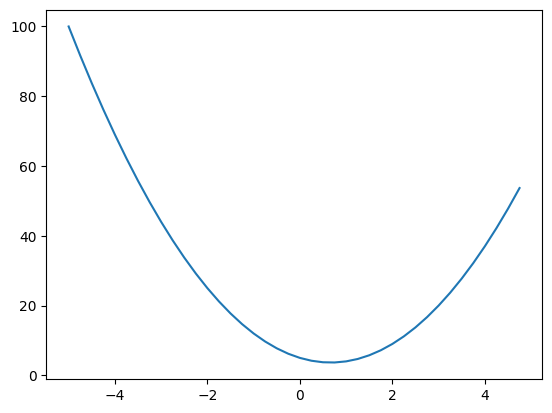

In [3]:
ys = f(xs)
ys
plt.plot(xs,ys)

In [4]:
h = 0.001
x = 3.0
(f(x+h)-f(x))/h

14.00300000000243

In [5]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [6]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a = a+h
d2 = a*b + c
print("d1",d1)
print("d2",d2)
print("Slope: ", (d2-d1)/h)

d1 4.0
d2 3.9999699999999994
Slope:  -3.000000000064062


In [7]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()





a = Value(2.0, label = 'a')
b = Value(-3.0, label ='b')
c = Value(10.0,label='c')
e = a*b
e.label = 'e'
d = a*b +c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f

L
L.tanh()

Value(data=-0.9999997749296758)

In [8]:
a = Value(2.0)
a+2

Value(data=4.0)

In [9]:
2*a

Value(data=4.0)

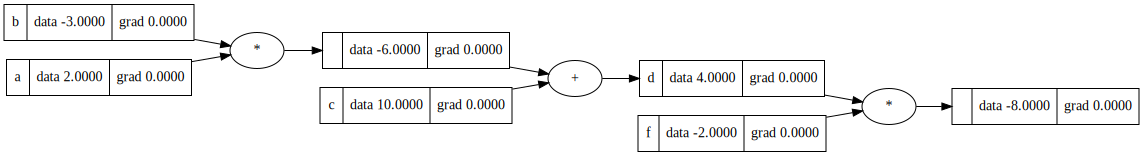

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s  |  data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

draw_dot(L)

dd/dc = ?

d = c+e

dd/dc = 1

dd/de = 1

dL/dc = dL/dd * dd/dc


In [11]:
e.grad = -2.0
c.grad = 2.0

In [12]:
def lol():
  h=0.001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label ='b')
  c = Value(10.0,label='c')
  e = a*b
  e.label = 'e'
  d = a*b +c
  d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f;L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label ='b')
  c = Value(10.0,label='c')

  e = a*b
  e.label = 'e'
  e.data += h
  d = e +c

  d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f;L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

lol()




-2.000000000000668


In [13]:
L.grad = 1

In [14]:
d.grad = -2.0
f.grad =4.0

In [15]:
e.grad = -2.0
c.grad = -2.0

In [16]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()


In [17]:
o.backward()

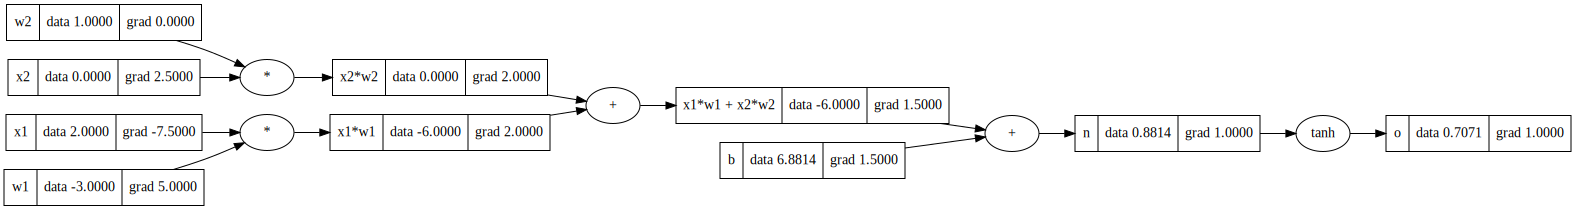

In [18]:
draw_dot(o)

In [29]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

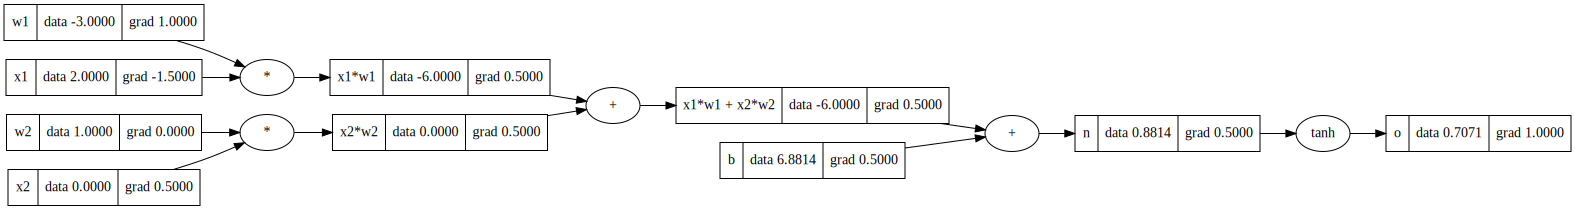

In [30]:
draw_dot(o)

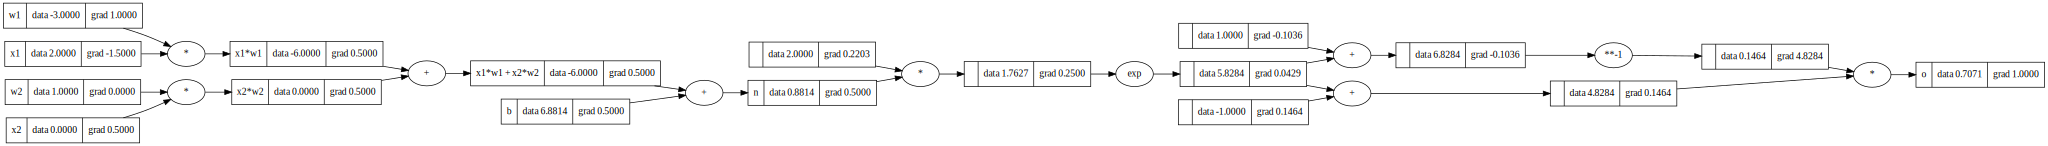

In [31]:


# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)



In [32]:
import torch

x1 = torch.Tensor([2.0]).double()            ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()           ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()          ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()           ;w2.requires_grad = True

b = torch.tensor([6.8813735870195432]).double()  ;b.requires_grad = True
n = x1*w1+x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print("---")
print('x2', x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [22]:
o.item()

0.7071066904050358

In [23]:
o


tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [45]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]



class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]



class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]








In [46]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)



Value(data=-0.510099704710221)

In [48]:
n.parameters()

[Value(data=-0.3205303088599074),
 Value(data=-0.7912867678244215),
 Value(data=0.0790089804538372),
 Value(data=0.31632038195289436),
 Value(data=0.29810550425217364),
 Value(data=0.4032687069689105),
 Value(data=-0.6775511345222487),
 Value(data=-0.8469331383714311),
 Value(data=-0.5997216736214541),
 Value(data=0.44161940864495297),
 Value(data=0.6876988250173004),
 Value(data=0.14771363254428294),
 Value(data=0.3785538105670161),
 Value(data=-0.2961387048739461),
 Value(data=-0.6538128898810407),
 Value(data=0.8166516001784312),
 Value(data=-0.19356470640429735),
 Value(data=-0.5554953892862231),
 Value(data=0.8871476911964782),
 Value(data=-0.9158722737689395),
 Value(data=0.9900532941578537),
 Value(data=0.4718647296916183),
 Value(data=0.9650862322342899),
 Value(data=0.2639393181968137),
 Value(data=-0.2803873638864014),
 Value(data=0.10721966464809252),
 Value(data=-0.9957168338877591),
 Value(data=-0.22325218926881818),
 Value(data=-0.6369443481880399),
 Value(data=0.54400966

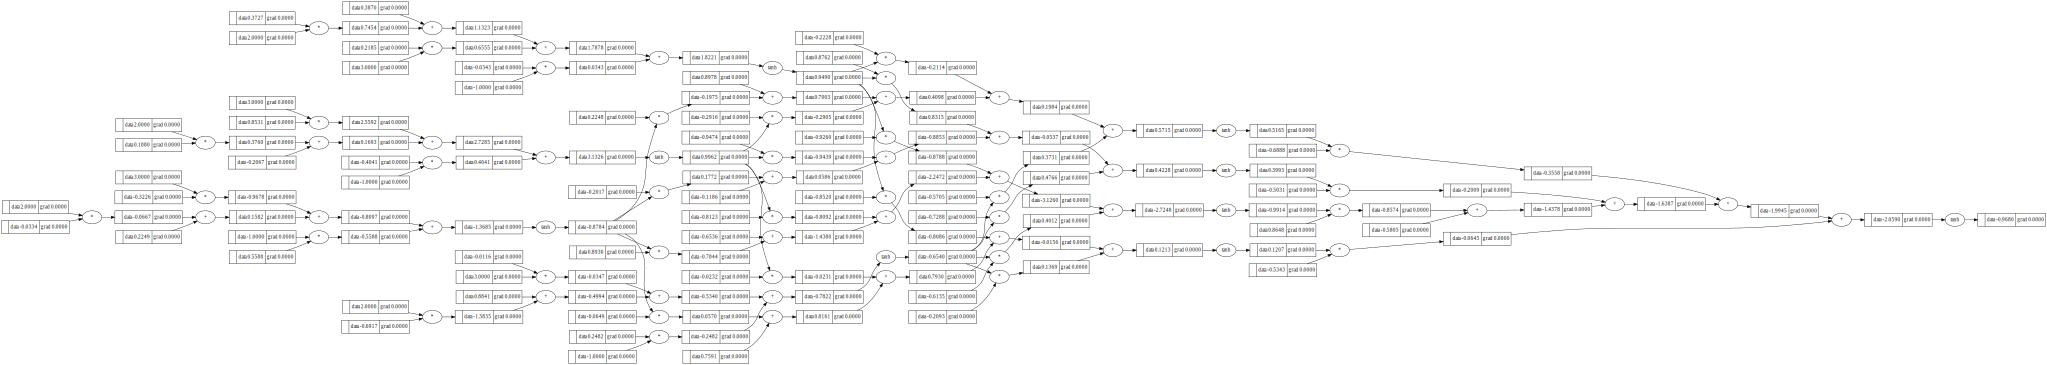

In [34]:
draw_dot(n(x))

In [49]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


ypred = [n(x) for x in xs]
ypred

[Value(data=-0.510099704710221),
 Value(data=-0.7443264983531337),
 Value(data=0.031546519523181604),
 Value(data=-0.6825923609836386)]

In [50]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.240975332791153)

In [51]:
loss.backward()

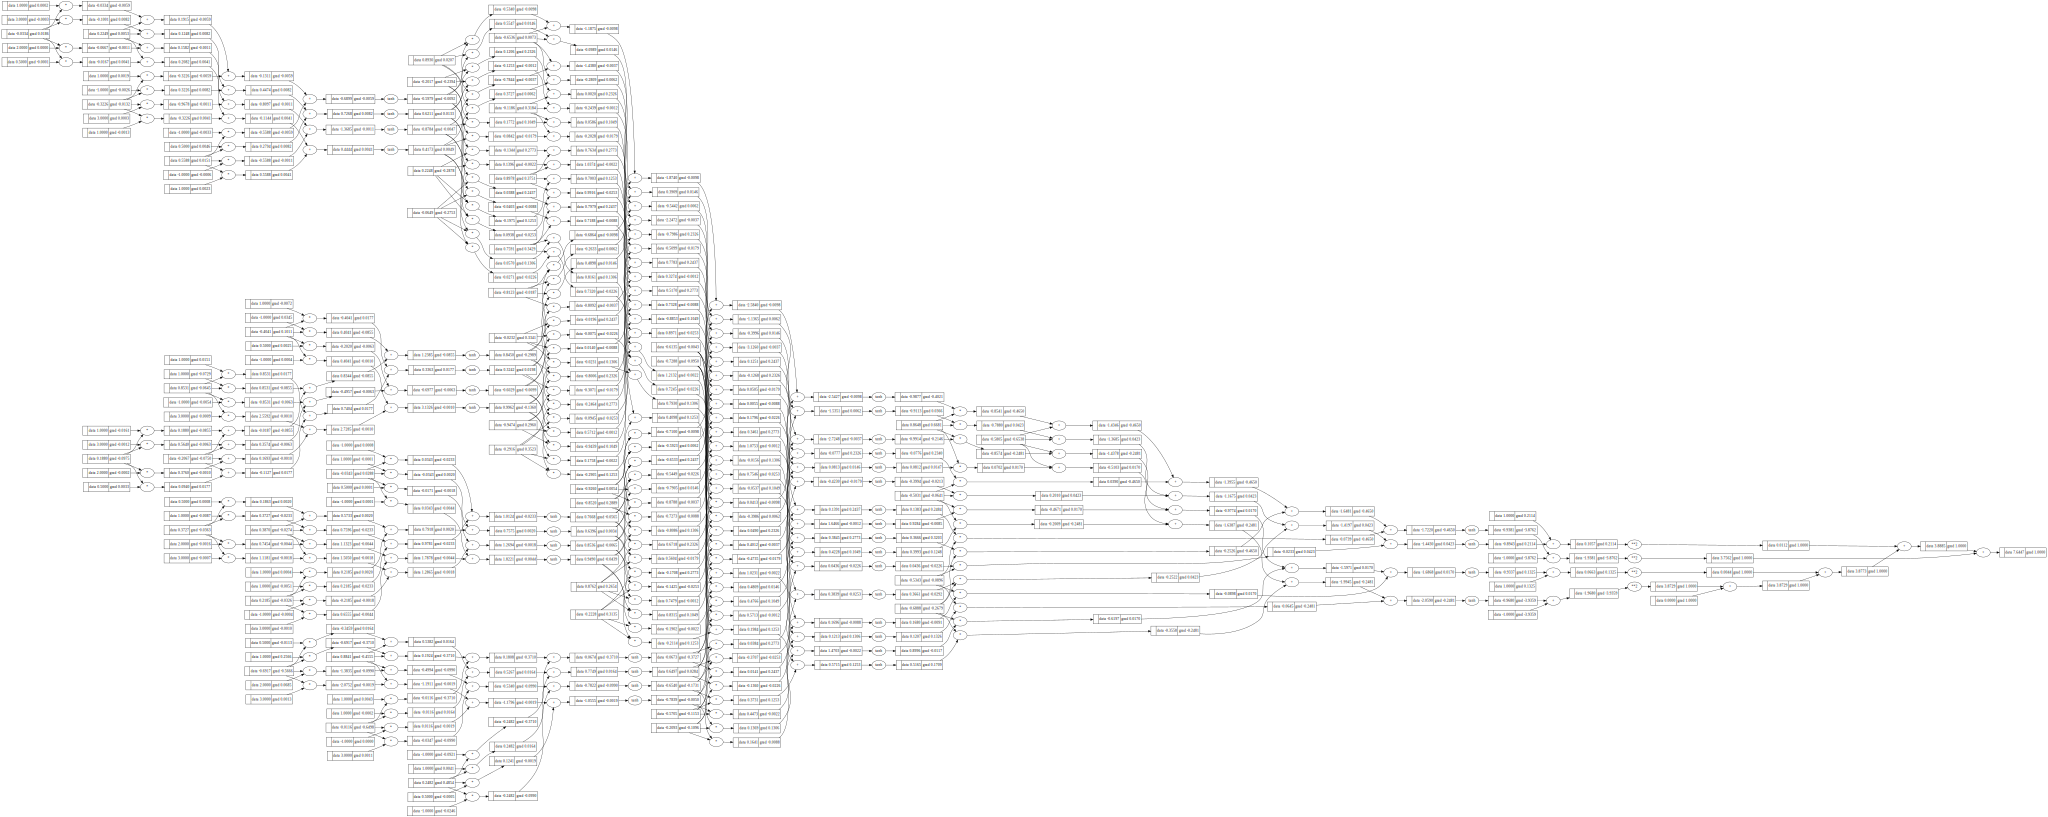

In [43]:
draw_dot(loss)

In [53]:
n.layers[0].neurons[0].w[0].grad

0.4816262351771683

In [54]:
n.layers[0].neurons[0].w[0].data

-0.3205303088599074

In [59]:
for k in range(20):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #backward pass
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.05*p.grad

  print(k,loss.data)

0 0.00011453081949541191
1 0.00011309759315755681
2 0.00011170288940129028
3 0.00011034513768072606
4 0.0001090228526277398
5 0.00010773462831844597
6 0.0001064791329985322
7 0.00010525510422503734
8 0.00010406134438658192
9 0.00010289671656805737
10 0.00010176014072910705
11 0.00010065059016894917
12 9.956708825269831e-05
13 9.85087053768781e-05
14 9.747455615387047e-05
15 9.646379679709459e-05
16 9.547562269030831e-05
17 9.450926612610328e-05
18 9.356399419990838e-05
19 9.263910684718562e-05
